# Assignment 3

The goal of this homework is to provide a realistic setting for a machine learning task.Therefore instructions will not specify the exact steps to carry out. Instead, it is part of the assignment to identify promising features, models and preprocessing methods and apply themas appropriate.

**The overall goal is to predict the price of a used vehicle on craigslist,** as can be found on kaggle: https://www.kaggle.com/austinreese/craigslist-carstrucks-data


You can find a description of the dataset and download it from there. *You do not have to usethe whole dataset, and it’s recommended that you strongly subsample the data whiledeveloping your solution.*

### Task 1 - Identify Features
- Assemble a dataset consisting of features and target (for example in a dataframe or in two arrays X and y).
- What features are relevant for the prediction task?
- Are there any features that should be excluded because they leak the target information?
- Show visualizations or statistics to support your selection.You are not required to use the description column, but you can try to come up with relevant features using it. Please don’t use bag-of-word approaches for now as we’ll discuss these later in the class.

Import libraries

In [35]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso

- Load only a subset of the dataset (20% is loaded)
- Drop columns that contain URLs and the description since NLP techniques are not going to be used in this ML project. Also vin and id (identification features)
- Drop rows with price = 0

In [10]:
n = 435849
skiprows = random.sample(range(1,n),int(n*0.8))
data = pd.read_csv("data/vehicles.csv", skiprows = skiprows)
drop_cols = ['id','url','region_url','image_url','description','vin']
data.drop(drop_cols,axis=1, inplace=True)

In [11]:
data.reset_index(drop=True,inplace=True)
data = data[data['price']!=0]

In [12]:
print(data.drop('price',axis=1).columns.values)

['region' 'year' 'manufacturer' 'model' 'condition' 'cylinders' 'fuel'
 'odometer' 'title_status' 'transmission' 'drive' 'size' 'type'
 'paint_color' 'county' 'state' 'lat' 'long']


- **Localization features:** Region, county, state, lat and long.
- **Car features:** manufacturer, model, cylinders, fuel, transmission, vin, drive, size, type,paint_color
- **State features:** year, condition, odometer, title_status

There are a lot of impossible prices such as '3333333' or '1234567' that add noise to our analysis. I will delete values higher than a threshold (and 0 values).

In [13]:
price_threshold = data['price'].quantile(q=0.999)
price_threshold

114799.20000000775

In [14]:
color = ['red' if i > price_threshold else 'k' for i in data['price']]
size = [10 if i > price_threshold else 1 for i in data['price']]
analysis = data[data['price']<price_threshold]

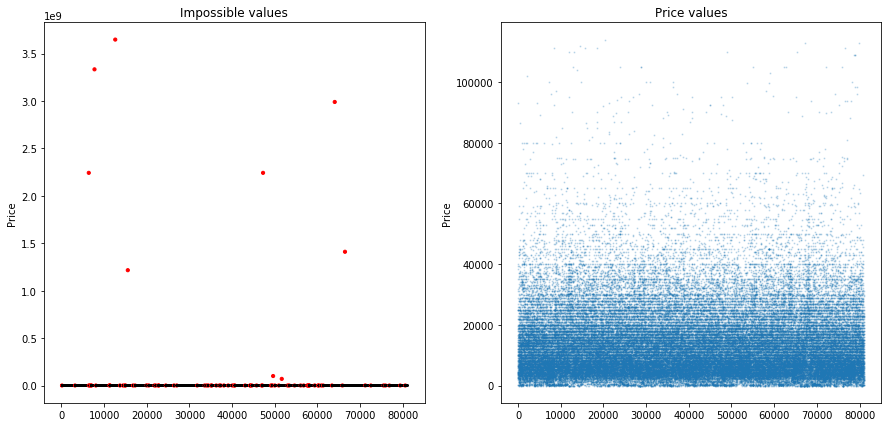

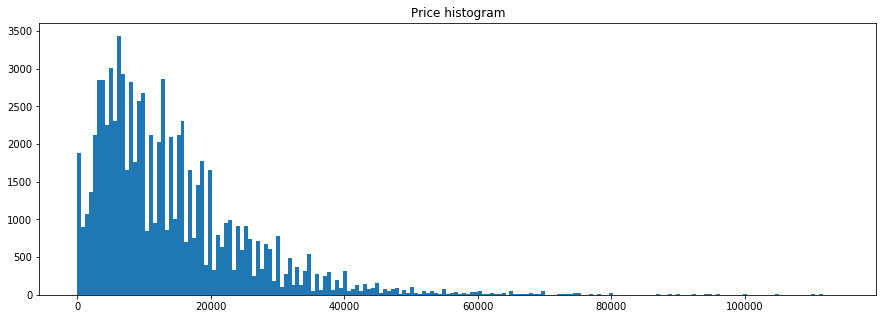

In [15]:
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,7))
ax[0].scatter(range(len(data['price'])),data['price'],s=size, c=color)
ax[1].scatter(range(len(analysis)),analysis['price'],s=1,alpha=0.2)

ax[1].set_title('Price values')
ax[0].set_title('Impossible values')
ax[0].set_ylabel('Price')
ax[1].set_ylabel('Price')

plt.show()

plt.figure(figsize=(15,5))
plt.hist(analysis['price'], bins='auto')
plt.title('Price histogram')
plt.show()

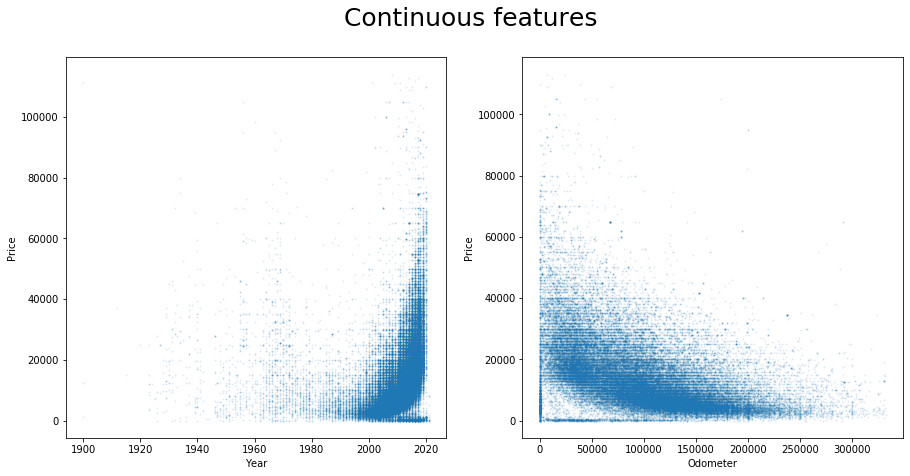

In [16]:
f, ax = plt.subplots(nrows = 1, ncols = 2,figsize=(15,7))

plt.suptitle('Continuous features',fontsize=25)

ax[0].scatter(analysis.year,
              analysis.price,
              s=1,alpha=0.1)

ax[0].set_xlabel('Year')
ax[0].set_ylabel('Price')


ax[1].scatter(analysis[analysis.odometer<analysis.odometer.quantile(.995)].odometer,
              analysis[analysis.odometer<analysis.odometer.quantile(.995)].price,
              s=1,alpha=0.1)

ax[1].set_xlabel('Odometer')
ax[1].set_ylabel('Price')

plt.show()

Once we eliminated noisy data, we can see clearly that this two features have a very strong correlation with the target.

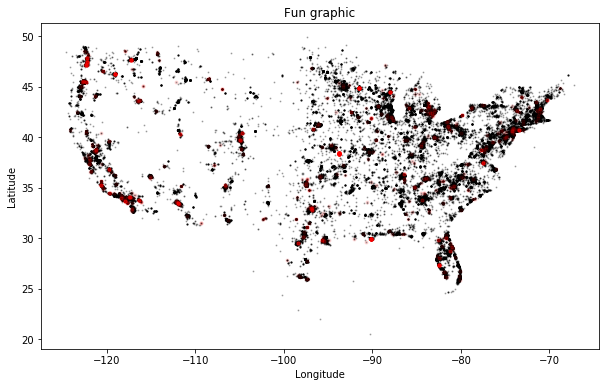

In [17]:
aa = analysis[(analysis['lat']>20)&(analysis['lat']<50)&(analysis['long']>-130)&(analysis['long']<-50)]
plt.figure(figsize=(10,6))
plt.scatter(aa.long,aa.lat,s=1,alpha=0.25,c='k')
plt.scatter(aa[aa['price']>50000].long,aa[aa['price']>50000].lat,s=10,alpha=0.1,c='r')
plt.title('Fun graphic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [18]:
cat = data.select_dtypes(include='object').columns
for c in cat:
    print(c,'-----> Unique values:',data[c].nunique())

region -----> Unique values: 402
manufacturer -----> Unique values: 42
model -----> Unique values: 13013
condition -----> Unique values: 6
cylinders -----> Unique values: 8
fuel -----> Unique values: 5
title_status -----> Unique values: 6
transmission -----> Unique values: 3
drive -----> Unique values: 3
size -----> Unique values: 4
type -----> Unique values: 13
paint_color -----> Unique values: 12
state -----> Unique values: 51


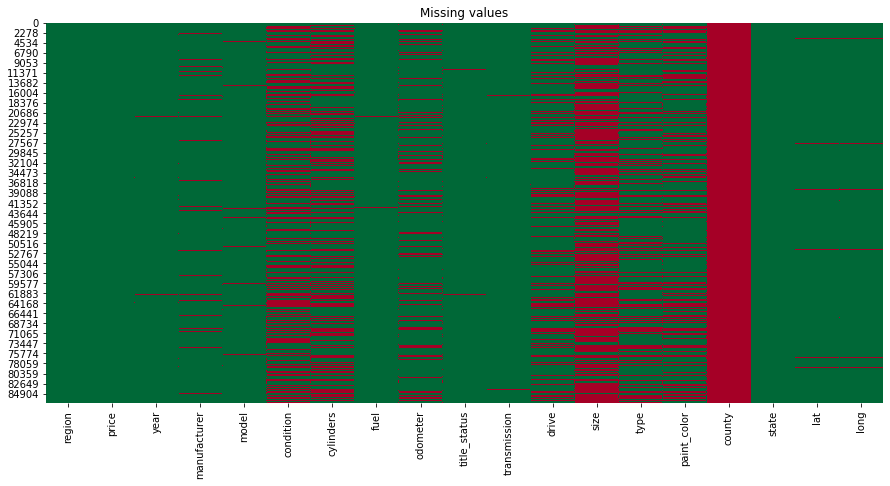

In [19]:
plt.figure(figsize=(15,7))
sns.heatmap(data.isnull(),cbar=False,cmap="RdYlGn_r")
plt.title('Missing values')
plt.show()

### Task 2 Preprocessing and Baseline Model
- Create a simple minimum viable model by doing:
    - an initial selection of features
    - appropriate preprocessing
    - cross-validating a linear model
    
    
- Feel free to exclude features or do simplified preprocessing for this task. 


*As mentioned before, you don’t need to validate the model on the whole dataset.*

###### Preprocessing
- Target encoding to categorical features with more than 15 categories
- One hot encoding to categorical features with less than 15 categories
- Median/mean to missing values
- Robust scaler to continuous features

In [20]:
categorical = ['region','manufacturer','condition','cylinders',
               'fuel','title_status','transmission','drive',
               'type','paint_color','state']

continuous = ['year','odometer','lat','long']

baseline = analysis[categorical + continuous + ['price']]

X_train, X_test, y_train, y_test = train_test_split(baseline.drop('price',axis=1),
                                                    baseline['price'],
                                                    test_size=0.2)

In [21]:
target_encoding = []
one_hot = []
for cat in categorical:
    if X_train[cat].nunique()>15:
        target_encoding.append(cat)
    else:
        one_hot.append(cat)

In [22]:
te = ce.TargetEncoder(cols = target_encoding)
ohe = ce.OneHotEncoder(cols = one_hot)
scaler = RobustScaler()

In [23]:
X_baseline = te.fit_transform(X_train,y_train)
X_baseline[target_encoding + continuous] = scaler.fit_transform(X_baseline[target_encoding + continuous])
X_baseline = ohe.fit_transform(X_baseline)

In [28]:
X_baseline = pd.DataFrame(SimpleImputer(strategy='most_frequent').fit_transform(X_baseline),
                          columns=X_baseline.columns)

In [36]:
bl_model = Lasso()
cv = cross_validate(bl_model,X_baseline,y_train,cv=7,scoring=['r2','neg_mean_absolute_error'])

In [38]:
pd.DataFrame(cv)

,fit_time,score_time,test_r2,test_neg_mean_absolute_error
0,1.732656,0.005409,0.377944,-5943.092280
1,1.911753,0.003711,0.360380,-5831.014865
2,1.387390,0.003701,0.392249,-5876.249737
3,2.079560,0.003701,0.397269,-5864.266992
4,1.038665,0.004090,0.374897,-5902.180714
5,1.979989,0.004200,0.405269,-5819.988413
6,2.728853,0.004057,0.383436,-5874.919044


In [49]:
bl_model.fit(X_baseline,y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [54]:
print('Top 20 features for Lasso')
sorted(zip(abs(bl_model.coef_),X_baseline.columns),reverse=True)[:20]

Top 20 features for Lasso


[(12745.002724823078, 'cylinders_9'),
 (6725.539514092861, 'title_status_6'),
 (6077.315863387769, 'condition_5'),
 (5863.479525494475, 'fuel_4'),
 (5610.567793271961, 'condition_6'),
 (4689.413172244499, 'condition_7'),
 (4398.924004689303, 'paint_color_12'),
 (3932.7809935367322, 'type_10'),
 (3638.9748562243403, 'type_4'),
 (3298.700261003212, 'title_status_4'),
 (3159.5157358694473, 'title_status_3'),
 (3015.4169140127797, 'cylinders_7'),
 (2605.873608491418, 'type_8'),
 (2468.7062270385695, 'cylinders_6'),
 (2443.257749591888, 'fuel_1'),
 (2352.5371717762805, 'year'),
 (2317.8173768749625, 'odometer'),
 (2160.0174556230063, 'type_6'),
 (2143.9225725898646, 'transmission_1'),
 (2132.733446405099, 'type_14')]

### Task 3 Feature Engineering
- Create derived features and perform more in-depth preprocessing and data cleaning. Does this improve your model? - In particular, think about how to encode categorical variables and whether adding interactions (for example using PolynomialFeatures or manually) might help.

### Task 4 Any model
- Use any regression model we discussed (trees, forests, gradient boosting, SVM) to improve your result.
- You can (and probably should) change your preprocessing and feature engineering to be suitable for the model. You are not required to try all of these models.
- Tune parametersas appropriate.

### Task 5 Feature Selections
- Identify features that are important for your best model. Which features are most influential,and which features could be removed without decrease in performance?
- Does removing irrelevant features make your model better? (This will be discussed in the lecture on 03/04).

### Task 6 An explainable model
- Can you create an “explainable” model that is nearly as good as your best model?
- An explainable model should be small enough to be easily inspected - say a linear model with few enough coefficients that you can reasonably look at all of them, or a tree with a small number of leaves etc.